In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import frame as fr
import algo_result as alg_res
import os
from sklearn import svm
from scipy.fft import fft, fftn, fftfreq, fftshift
from scipy.signal import spectrogram
%run algo_process.ipynb


In [2]:
SAMPLES_PER_CHIRP = 128
CHIRPS_PER_FRAME = 16
T = 300e-6
SPEED_OF_LIGHT = 3e8
START_FREQUENCY = 24.025e9
B = 200e6
PULSE_REPETITION_INTERVAL = 500e-6
SAMPLE_PERIOD = T/SAMPLES_PER_CHIRP
SAMPLE_FREQUENCY = 1/SAMPLE_PERIOD
LAMBDA = SPEED_OF_LIGHT/START_FREQUENCY
RANGE_PAD = 256
DOPPLER_PAD = 64
ANTENNA_SPACING = 6.22e-3

PEAK_THRESHOLD = 0.01 # normalized FFT absolute minimum strength 
PEAK_SLICE = 2 #meters around target
PEAK_WIDTH = 1 #integer
PEAK_RELEVANCE = 0 #minimum distance between pvl1,pvr1 and pvc
SEARCH_ZONE = 30 #split spectrum in slices of SEARCH_ZONE meters to find a single peak

ANGLE_CALIBRATION = -150
ANGLE_PRECISION = 1

ANTENNA_NUMBER = 2

FRAME_REP_INTERVAL = 0.1

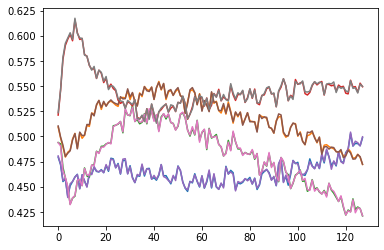

In [3]:
calibration_data = pd.read_csv('../../data/Classification_data_KAUST/environment_test.txt', sep='\t', header=None)
calibration = calibration_data.select_dtypes(include = ['float']).values
calibration_frame = fr.Frame(calibration[0*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP:(0+1)*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP,:],\
                           SAMPLES_PER_CHIRP, CHIRPS_PER_FRAME, ANTENNA_NUMBER, T)

average_calib_chirp = np.zeros((SAMPLES_PER_CHIRP,ANTENNA_NUMBER),dtype=complex)
for chirp in range(CHIRPS_PER_FRAME):
    average_calib_chirp += calibration_frame.get_chirp(chirp)
average_calib_chirp /= CHIRPS_PER_FRAME
#averaged
plt.plot(np.real(average_calib_chirp))
plt.plot(np.imag(average_calib_chirp))
#non averaged
plt.plot(np.real(calibration_frame.chirp[:,:,0]))
plt.plot(np.imag(calibration_frame.chirp[:,:,0]))
plt.show()

../Classification_data_KAUST/biking_mixed_128_test_2.txt


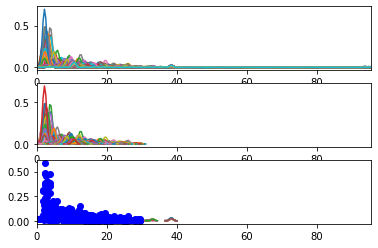

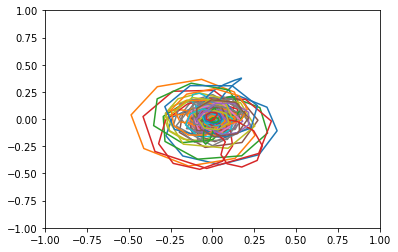

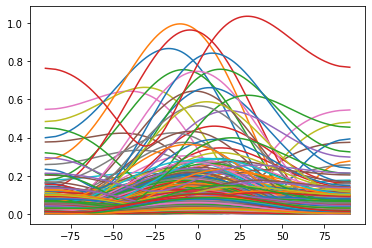

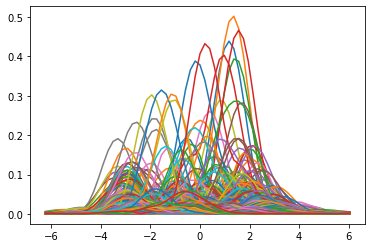

In [20]:
directory = os.fsencode('../../data/Classification_data_KAUST/')
    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    #(filename.startswith('biking_mixed') or filename.startswith('walking_mixed'))
    if filename != 'Sky.txt' and filename.endswith('.txt') and filename.startswith('biking_mixed_128_test_1') :
        path = os.path.join(os.fsdecode(directory), filename)
        print(path)                    
        data = pd.read_csv(path, sep='\t', header=None)
        data.columns = ["idx","I_RX1","Q_RX1","I_RX2","Q_RX2"]
        
        recording = data.select_dtypes(include = ['float']).values
        FRAME_NUMBER = len(data)//(SAMPLES_PER_CHIRP*CHIRPS_PER_FRAME)
        Hu_bi_frame = []
        ###Create dataset
        for frame in range(FRAME_NUMBER):
            Hu_bi_frame.append(fr.Frame(recording[frame*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP:(frame+1)*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP,:],\
                                   SAMPLES_PER_CHIRP, CHIRPS_PER_FRAME, ANTENNA_NUMBER, T)) 
        ###Calibrate frames
        for frame in range(FRAME_NUMBER):
            Hu_bi_frame[frame].calibrate(average_calib_chirp)

        xf = np.arange(0,RANGE_PAD)
        range_bin = xf*T*SPEED_OF_LIGHT/(2*B)/(T/SAMPLES_PER_CHIRP)/RANGE_PAD
        range2bin = 1/(T/SAMPLES_PER_CHIRP)/RANGE_PAD*T*SPEED_OF_LIGHT/(2*B)
        vel_bin = fftshift(fftfreq(DOPPLER_PAD,PULSE_REPETITION_INTERVAL))*SPEED_OF_LIGHT/(2*START_FREQUENCY) 

        Target_observations = []
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
        ax1.set_xlim(range_bin[0],range_bin[-1])
        ax2.set_xlim(range_bin[0],range_bin[-1])
        ax3.set_xlim(range_bin[0],range_bin[-1])
        fig, ax4 = plt.subplots(1, 1)
        fig, ax5 = plt.subplots(1, 1)
        fig, ax6 = plt.subplots(1, 1)
        ax4.set_xlim(-1,1)
        ax4.set_ylim(-1,1)
        Target_info_list = []
        Target_presence_list = []
        ###Process frames
        for frame in range(FRAME_NUMBER):
            data_out,target_info = algo_process(Hu_bi_frame[frame],RANGE_PAD,CHIRPS_PER_FRAME,DOPPLER_PAD,PEAK_THRESHOLD,PEAK_SLICE,PEAK_WIDTH,PEAK_RELEVANCE,SEARCH_ZONE,ANGLE_CALIBRATION,ANGLE_PRECISION,round(LAMBDA/ANTENNA_SPACING),range2bin)
            if(target_info.num_targets > 0):
                Target_info_list.append(target_info)
                Target_presence_list.append(1)
            else:
                Target_presence_list.append(0)  
            ax1.plot(range_bin,np.abs((data_out[:,0,0].T)))
            for target in range(target_info.num_targets):
                if target_info.location[target] < SEARCH_ZONE:
                    ax3.plot(target_info.location[target], target_info.strength[target],'bo')
                    ax2.plot(target_info.print_location[:,target],target_info.print[:,0,target])
                    ax4.plot(np.real(target_info.doppler_mark[:,target]),np.imag(target_info.doppler_mark[:,target]))
                    ax5.plot(target_info.angle,target_info.angle_spectrum[:,target])
                    ax6.plot(vel_bin,target_info.doppler_spectrum[:,target])
                    Target_observations.append(np.append(target_info.print[:,:,target].T,target_info.location[target]))
                elif target_info.location[target] > SEARCH_ZONE:
                    ax3.plot(target_info.print_location[:,target],target_info.print[:,0,target])
        
        plt.show()
        df = pd.DataFrame(Target_observations).T
        output_path = "../data_out/"
        
        output_filename = filename.split('.')[0]+'_out'
        extension = '_concatenate_chirps.txt'
        df.T.to_csv(output_path+output_filename+extension, sep='\t',index=False, header=False) 

(64, 1200)


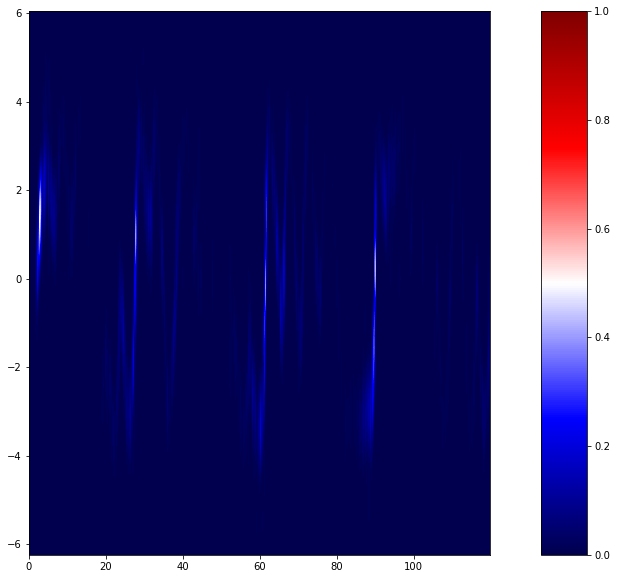

In [22]:
import matplotlib as mpl

target_doppler_spec = np.zeros((DOPPLER_PAD,1))
idx = 0
for target_presence in Target_presence_list:
    if target_presence:
        target_doppler_spec = np.append(target_doppler_spec, Target_info_list[idx].doppler_spectrum[:,0].reshape((DOPPLER_PAD,1)), axis=1)
        idx += 1
    else:
        target_doppler_spec = np.append(target_doppler_spec, np.zeros((DOPPLER_PAD,1)), axis=1)
target_doppler_spec = target_doppler_spec[:,1:]
print(target_doppler_spec.shape)


fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1]}, figsize=[10,10])
ax.clear()
cmap = mpl.cm.get_cmap('seismic')
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
levels = np.linspace(0.0, 1, 100)
ax.contourf(np.arange(0,FRAME_NUMBER)*FRAME_REP_INTERVAL,vel_bin,target_doppler_spec, levels, cmap=cmap, norm=norm)
#plt.savefig('biking_mixed_test_1.png')
            

In [6]:

frame_counter = 0
frame_time = np.linspace(0,PULSE_REPETITION_INTERVAL*CHIRPS_PER_FRAME,CHIRPS_PER_FRAME).reshape((CHIRPS_PER_FRAME,1))
frame_time_list = frame_time.reshape((CHIRPS_PER_FRAME,1))
for target_presence in Target_presence_list:
    if target_presence:
        frame_time_list = np.append(frame_time_list,frame_time+FRAME_REP_INTERVAL*frame_counter,axis=1)
    frame_counter += 1
frame_time_list = frame_time_list[:,1:]

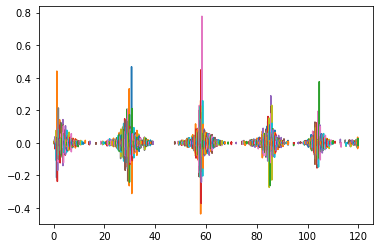

In [7]:
fig,ax = plt.subplots(1,1)
valid_frames = sum(Target_presence_list)
for idx in range(valid_frames):
    ax.plot(frame_time_list[:,idx],np.real(Target_info_list[idx].doppler_mark[:,0]))

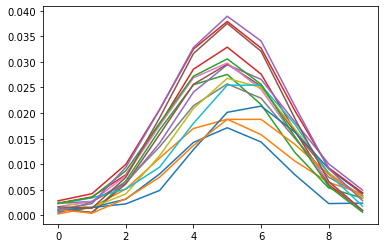

In [8]:
plt.plot(target_info.print[:,:,0])

In [9]:
target_info.print[:,:,0].T

array([[0.00110576, 0.00156116, 0.00316774, 0.00810541, 0.01427333,
        0.01713128, 0.01435128, 0.00795642, 0.00232061, 0.00240377],
       [0.00029814, 0.00158641, 0.00516806, 0.01121124, 0.01699281,
        0.01880353, 0.01578616, 0.0106201 , 0.00644662, 0.00428287],
       [0.00147903, 0.00049666, 0.0067359 , 0.01672977, 0.02554019,
        0.02755649, 0.02165851, 0.01230595, 0.00537233, 0.00338473],
       [0.00238937, 0.00362814, 0.00795052, 0.01780877, 0.0285722 ,
        0.03287784, 0.02761537, 0.01653516, 0.00603506, 0.00093542],
       [0.00235367, 0.0027498 , 0.006218  , 0.0141396 , 0.02408602,
        0.02946335, 0.02658885, 0.01825408, 0.01007845, 0.00495214],
       [0.00114445, 0.00060692, 0.00617276, 0.01583521, 0.02562052,
        0.02955292, 0.02525862, 0.01633892, 0.00823831, 0.0034792 ],
       [0.00171021, 0.00272884, 0.0077643 , 0.01756648, 0.02688609,
        0.02978073, 0.02466375, 0.01528491, 0.00655525, 0.00092579],
       [0.0004848 , 0.00266914, 0.0065743

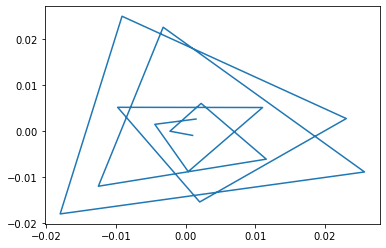

In [10]:
plt.plot(np.real(target_info.doppler_mark[:,target]),np.imag(target_info.doppler_mark[:,target]))

In [11]:
print(np.sum(Target_info_list[0].doppler_spectrum[:,0])/4)
print(np.sqrt(np.sum(Target_info_list[0].doppler_mark[:,0]*np.conj(Target_info_list[0].doppler_mark[:,0]))))

0.06359277802612043
(0.0733692673301402+0j)
